In [17]:
import os
import torch
import torchaudio
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor()])

# Dataset class
class AudioSpectrogramDataset(Dataset):
    def __init__(self, slices, labels, sample_rate=16000, transform=None):
        self.slices = slices
        self.labels = labels
        self.sample_rate = sample_rate
        self.transform = transform

    def __getitem__(self, idx):
        waveform = self.slices[idx]
        label = self.labels[idx]

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

    def __len__(self):
        return len(self.slices)

file_paths = []

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size
        mean += images.mean(axis=(0, 2, 3)).sum() * batch_size
        std += images.std(axis=(0, 2, 3)).sum() * batch_size

    mean /= num_pixels
    std /= num_pixels

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#../sliced_spectograms_no_silence/

full_dataset = datasets.ImageFolder(root='sliced_spectograms_no_silence\\',transform=transform)



# from imblearn.over_sampling import SMOTE
# import numpy as np

# # Get the data and labels from your dataset
# data = [full_dataset.samples[i][0] for i in range(len(full_dataset))]
# labels = [full_dataset.samples[i][1] for i in range(len(full_dataset))]

# # Oversample the minority class
# smote = SMOTE(random_state=42)
# balanced_data, balanced_labels = smote.fit_resample(np.array(data).reshape(-1, 1), labels)

# # Update the dataset
# balanced_dataset = datasets.ImageFolder(root='../sliced_spectograms_no_silence/', transform=transform)
# balanced_dataset.samples = list(zip(balanced_data.ravel(), balanced_labels))

# # DataLoader for balanced dataset
# balanced_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)
# mean, std = get_mean_std(loader)
# normalize = transforms.Compose([
#     transforms.Normalize(mean=mean,std=std) #To fix later
# ])
# balanced_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True,transform = normalize)

# from collections import Counter

# # Count classes in the dataset
# train_counts = Counter([label for _, label in train_subset])
# test_counts = Counter([label for _, label in test_subset])

# print(f"Train Class Distribution: {train_counts}")
# print(f"Test Class Distribution: {test_counts}")

loader = DataLoader(full_dataset, batch_size=32, shuffle=True,num_workers=4, pin_memory=True)
mean, std = get_mean_std(loader)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)])

normalized_dataset = datasets.ImageFolder(root='sliced_spectograms_no_silence\\',transform=transform)

print(mean)
print(std)

images = list(range(len(normalized_dataset)))
    

# Split into training and testing
# train_files, test_files = train_test_split(
#     images,
#     test_size=0.2,
#     random_state=42
# )

train_indices = []
test_indices = []

# Iterate through all samples to create indices based on the condition
for i, (image, label) in enumerate(normalized_dataset):
    file_path, _ = normalized_dataset.samples[i]  # `full_dataset.samples` is a list of (file_path, class) tuples
    
    if "script5" in os.path.basename(file_path):
        test_indices.append(i)
    else:
        train_indices.append(i)

# Create training and testing subsets based on indices
train_subset = torch.utils.data.Subset(normalized_dataset, train_indices)
test_subset = torch.utils.data.Subset(normalized_dataset, test_indices)

# train_subset = torch.utils.data.Subset(full_dataset, train_files)
# test_subset = torch.utils.data.Subset(full_dataset, test_files)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True) # change to 16? set workers to number of cpu cores ot less
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


tensor(0.7412)
tensor(0.2613)


In [146]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print("CUDA available:", torch.cuda.is_available())  # Should print True
print("CUDA device count:", torch.cuda.device_count())  # Number of GPUs

cuda
CUDA available: True
CUDA device count: 1


In [148]:
import torch.nn as nn
import torch.nn.functional as F

INPUT_RESOLUTION=128

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 60, 5) #*10/ if overfit drop/ one layer + pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(60, 160, 3)
        self.fc1 = nn.Linear(160 * (INPUT_RESOLUTION//4 -2 ) * (INPUT_RESOLUTION//4 - 2), 1200)
        self.fc2 = nn.Linear(1200, 840)
        self.fc3 = nn.Linear(840, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [150]:
import torch.optim as optim

LEARNING_RATE = 0.005
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM)
#optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
num_learnable_parameters = sum([
    p.numel() for p in net.parameters() if p.requires_grad
])
#random crop

In [152]:
import wandb
wandb.login()
wandb.init(
    project="IML",
    config={
        "learning_rate": LEARNING_RATE,
        "learning_rate_decay": MOMENTUM,
        "batch_size": train_loader.batch_size,
        "input_resolution": INPUT_RESOLUTION,
        "num_parameters": num_learnable_parameters,
        "architecture": "CNN",
        "dataset": "DAPS"
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [154]:
net.to(device)
PRINT_STEP = len(train_loader) // 5 - 1
# PRINT_STEP = 20
# Initialize counters
correct_class_0 = 0  
incorrect_class_0 = 0  
correct_class_1 = 0  
incorrect_class_1 = 0 

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

# Counters for total samples in each class
total_class_0 = 0
total_class_1 = 0
print('Starting Training')
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    scaler = torch.GradScaler('cuda') if torch.cuda.is_available() else None    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        #trying mixed precision training for better performance
        if (scaler):
            
            with torch.amp.autocast('cuda'):
                outputs = net(inputs)
                loss = criterion(outputs, labels)# Automatically casts to lower precision
            scaler.scale(loss).backward()  # Scales gradients
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # forward + backward + optimize
        # outputs = net(inputs)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()
        _, predictions = torch.max(outputs.data, 1)
        correct += (predictions == labels).float().mean().item()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_STEP == PRINT_STEP-1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')

            accuracy = correct / PRINT_STEP
            loss = running_loss / PRINT_STEP
            step = epoch * len(train_loader) + i
            wandb.log({
                    "train/accuracy": accuracy,
                    "train/loss": loss
                },
                step=step
            )
            running_loss = 0.0
            correct = 0

    net.eval()
    test_loss = 0.0
    test_correct = 0
    misclassified_inputs = []
    misclassified_labels = []
    misclassified_predictions = []
    misclassified_file_paths = []
    with torch.no_grad():
        for j, data in enumerate(test_loader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            test_correct += (predictions == labels).float().mean().item()
            
            for label, prediction, input,idx in zip(labels, predictions,inputs,range(len(inputs))):
                file_path = normalized_dataset.samples[test_subset.indices[j * test_loader.batch_size + idx]][0]
                if label == 0:
                    total_class_0 += 1
                    if prediction == 0:
                        true_negative += 1
                        correct_class_0 += 1
                    else:
                        incorrect_class_0 += 1  # False Acceptance
                        false_positive += 1
                        misclassified_file_paths.append(file_path)
                        misclassified_inputs.append(input.cpu())
                        misclassified_labels.append(label.cpu())
                        misclassified_predictions.append(prediction.cpu())
                elif label == 1:
                    total_class_1 += 1
                    if prediction == 1:
                        correct_class_1 += 1
                        true_positive += 1
                    else:
                        incorrect_class_1 += 1  # False Rejection
                        false_negative += 1
                        misclassified_file_paths.append(file_path)
                        misclassified_inputs.append(input.cpu())
                        misclassified_labels.append(label.cpu())
                        misclassified_predictions.append(prediction.cpu())

    accuracy = test_correct / len(test_loader)
    loss = test_loss / len(test_loader)
    wandb.log({
            "validation/accuracy": accuracy,
            "validation/loss": loss
        },
        step = (epoch + 1) * len(train_loader)
    )
    net.train()
    # scheduler.step()

wandb.finish()

print('Finished Training')

PATH = './net4.pth'
torch.save(net.state_dict(), PATH)

Starting Training
[1,   157] loss: 5.073
[1,   314] loss: 4.227
[1,   471] loss: 3.212
[1,   628] loss: 2.575
[1,   785] loss: 2.096
[2,   157] loss: 1.481
[2,   314] loss: 1.220
[2,   471] loss: 1.013
[2,   628] loss: 0.807
[2,   785] loss: 0.728
[3,   157] loss: 0.386
[3,   314] loss: 0.425
[3,   471] loss: 0.394
[3,   628] loss: 0.360
[3,   785] loss: 0.405


Finished Training


In [158]:
import pandas as pd
misclassified_data = {
    'input':  misclassified_file_paths,
    'true_label': misclassified_labels,
    'predicted_label': misclassified_predictions,
}

misclassified_df = pd.DataFrame(misclassified_data)

                                               input true_label  \
0  C:\Users\Sıla Solak\Desktop\IML project\sliced...  tensor(0)   
1  C:\Users\Sıla Solak\Desktop\IML project\sliced...  tensor(0)   
2  C:\Users\Sıla Solak\Desktop\IML project\sliced...  tensor(0)   
3  C:\Users\Sıla Solak\Desktop\IML project\sliced...  tensor(0)   
4  C:\Users\Sıla Solak\Desktop\IML project\sliced...  tensor(0)   

  predicted_label  
0       tensor(1)  
1       tensor(1)  
2       tensor(1)  
3       tensor(1)  
4       tensor(1)  


In [210]:
import os

def extract_info(file_path):
    file_name = os.path.basename(file_path)  
    parts = file_name.split('_')  
    person = parts[0];
    gender = 'female' if person[0] == 'f' else 'male' 
    recording_type = parts[2] if parts[3][0].isdigit() else parts[2] +'_'+ parts[3]
    return gender, recording_type, person,file_name

misclassified_df[['gender', 'recording_type','person','file_name']] = misclassified_df['input'].apply(lambda x: pd.Series(extract_info(x)))

In [160]:
misclassified_class_0 = misclassified_df[misclassified_df['true_label'] == 0]
misclassified_class_1 = misclassified_df[misclassified_df['true_label'] == 1]

print(f'Misclassified Class 0: {len(misclassified_class_0)}')
print(f'Misclassified Class 1: {len(misclassified_class_1)}')

Misclassified Class 0: 215
Misclassified Class 1: 264


In [212]:
gender_counts = misclassified_df['gender'].value_counts()
gender_counts

gender
female    305
male      174
Name: count, dtype: int64

In [214]:
recording_counts = misclassified_df['recording_type'].value_counts()
recording_counts

recording_type
iphone_balcony1       120
ipad_balcony1          70
ipad_office1           28
ipad_confroom2         26
iphone_bedroom1        26
ipadflat_confroom1     25
produced               25
ipad_livingroom1       23
cleanraw               22
iphone_livingroom1     22
ipadflat_office1       20
ipad_confroom1         19
clean                  18
ipad_office2           18
ipad_bedroom1          17
Name: count, dtype: int64

In [250]:
person_counts = misclassified_df['person'].value_counts()
person_counts

person
f8     79
m3     50
f3     50
m6     46
f2     41
f7     37
f10    27
m9     26
f6     21
f4     17
f1     15
f5     12
m4     11
m5     10
m8     10
m1      7
m7      6
f9      6
m2      5
m10     3
Name: count, dtype: int64

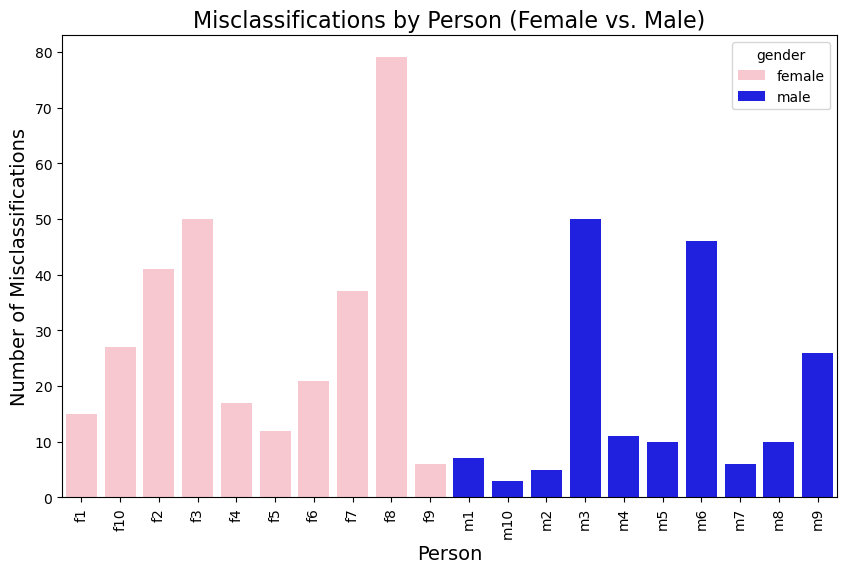

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

person_counts_with_gender = misclassified_df.groupby(['person', 'gender']).size().reset_index(name='misclassifications')

color = {'female': 'pink', 'male': 'blue'}

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=person_counts_with_gender, x='person', y='misclassifications', hue='gender', palette=color)

# Add title and labels
plt.title('Misclassifications by Person (Female vs. Male)', fontsize=16)
plt.xlabel('Person', fontsize=14)
plt.ylabel('Number of Misclassifications', fontsize=14)
plt.xticks(rotation=90)  # Rotate person labels if necessary
plt.show()

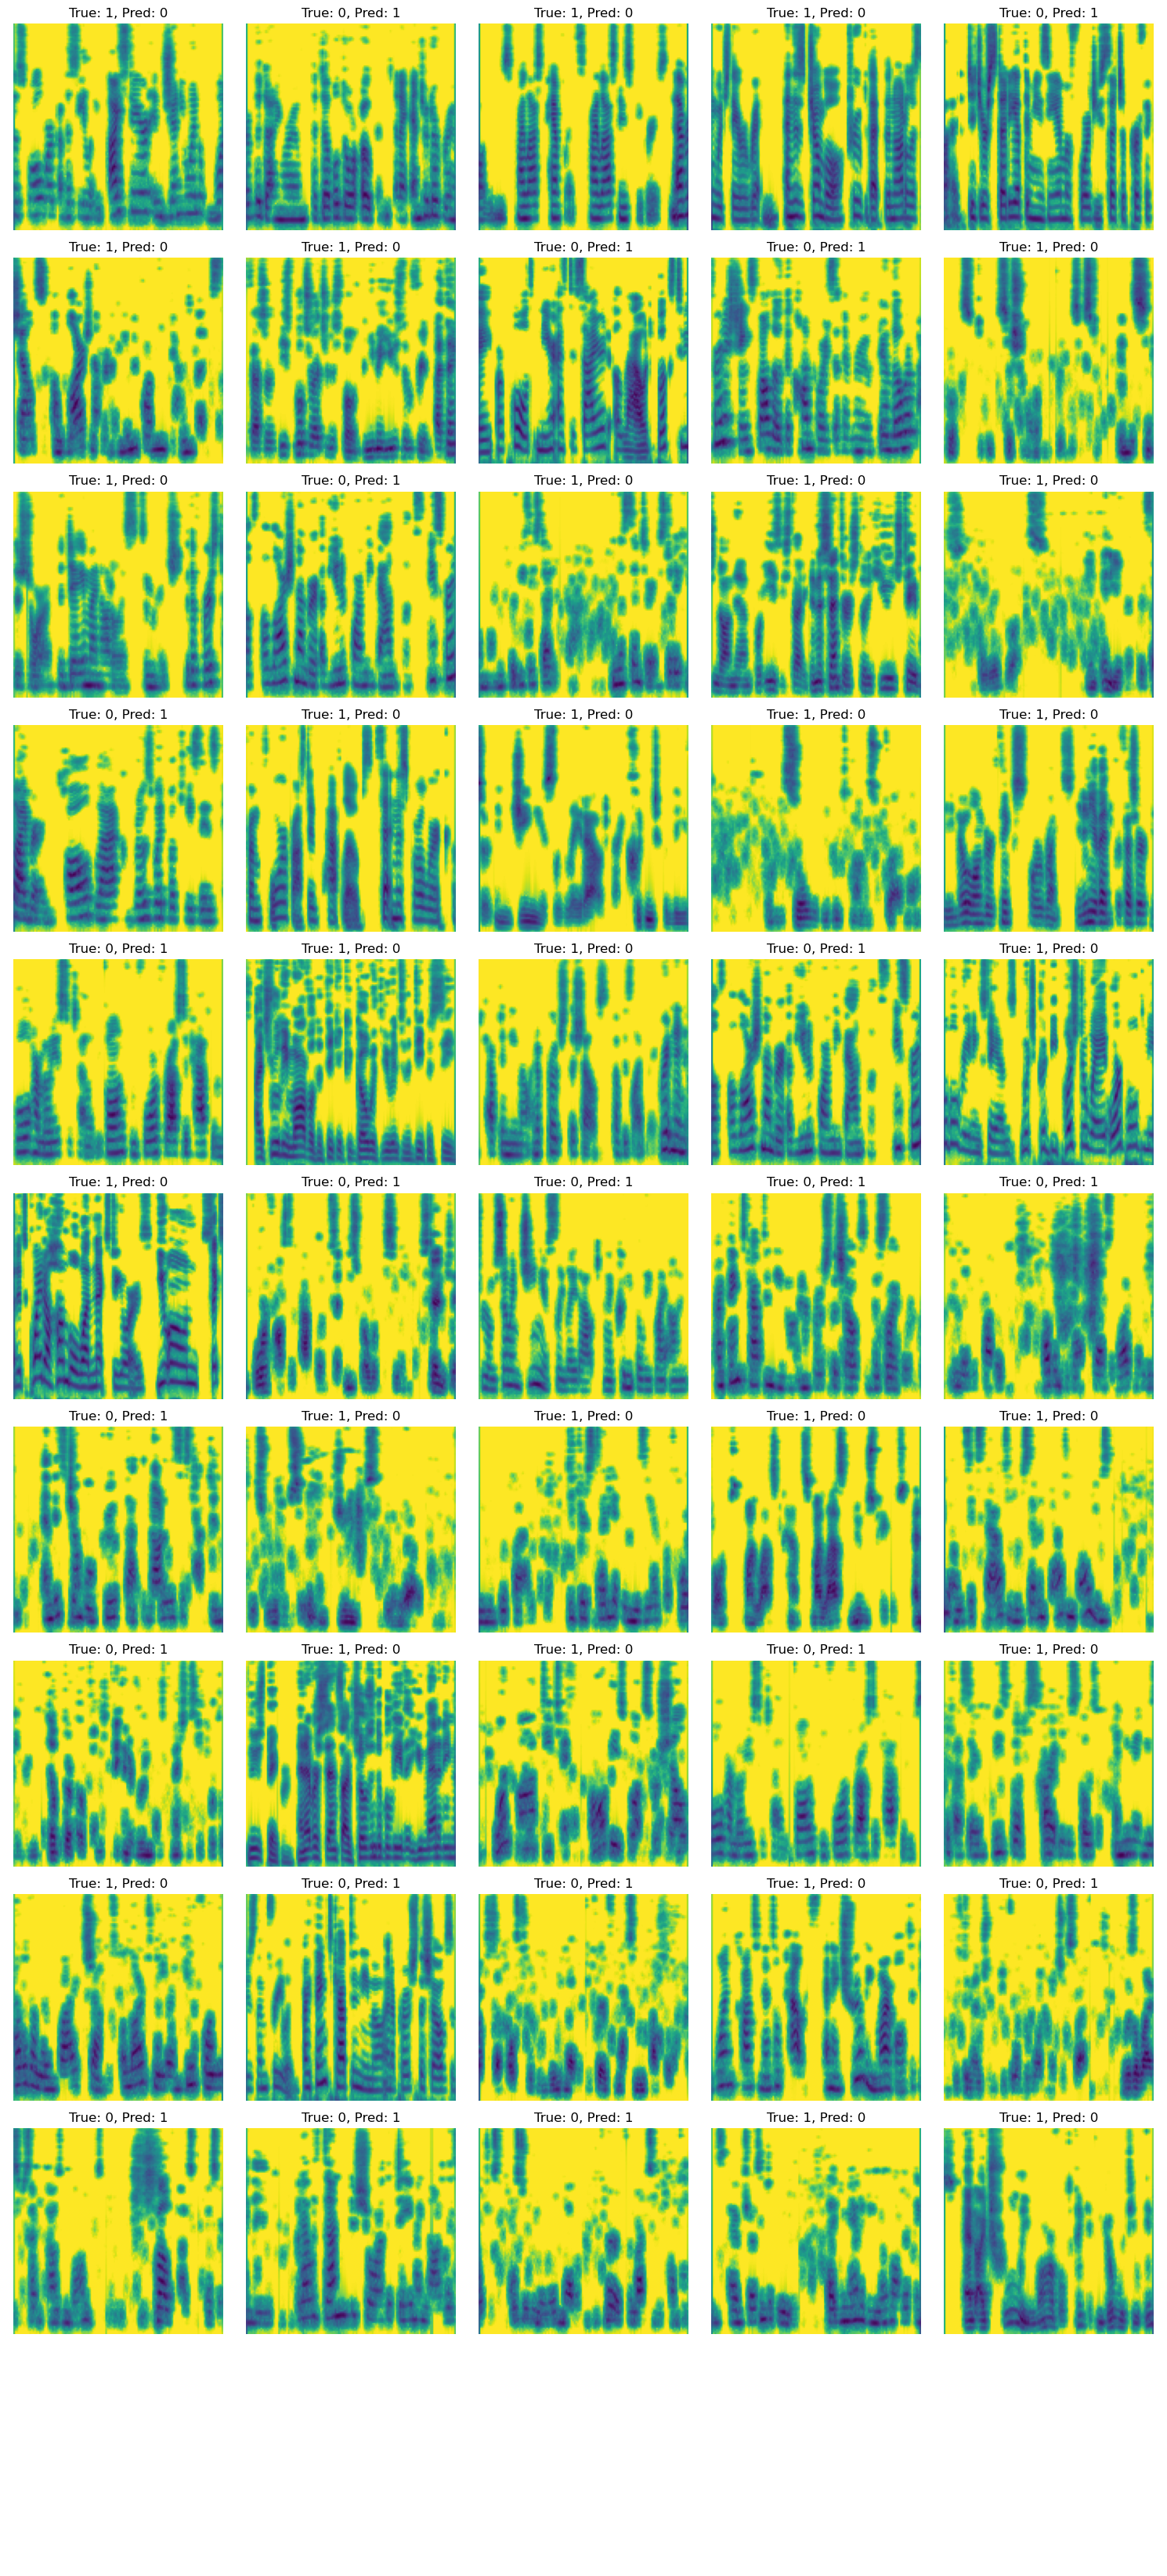

In [274]:
import matplotlib.pyplot as plt
import random
from PIL import Image

num_images_to_display = 50
images_per_row = 5
num_rows = num_images_to_display // images_per_row + 1

random_indices = random.sample(range(len(misclassified_file_paths)), num_images_to_display)
random_file_paths = [misclassified_file_paths[i] for i in random_indices]
random_true_labels = [misclassified_labels[i] for i in random_indices]
random_predicted_labels = [misclassified_predictions[i] for i in random_indices]

# Create the plot
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
axes = axes.flatten()  


for i, file_path in enumerate(random_file_paths):
    img = Image.open(file_path)
    
    true_label = random_true_labels[i]
    predicted_label = random_predicted_labels[i]
    
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f'True: {true_label}, Pred: {predicted_label}')
    ax.axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [39]:
# net = Net()
# PATH = './net2.pth'
# net.load_state_dict(torch.load(PATH, weights_only=True))

# # Initialize counters
# correct_class_0 = 0  
# incorrect_class_0 = 0  
# correct_class_1 = 0  
# incorrect_class_1 = 0 

# true_positive = 0
# false_positive = 0
# true_negative = 0
# false_negative = 0

# # Counters for total samples in each class
# total_class_0 = 0
# total_class_1 = 0

# net.eval()
# test_loss = 0.0
# test_correct = 0
# with torch.no_grad():
#     for j, data in enumerate(test_loader, 0):
#         inputs, labels = data
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         val_loss += loss.item()
#         _, predictions = torch.max(outputs.data, 1)
#         val_correct += (predictions == labels).float().mean().item()
        
#         for label, prediction in zip(labels, predicted):
#             if label == 0:
#                 total_class_0 += 1
#                 if prediction == 0:
#                     true_negative += 1
#                     correct_class_0 += 1
#                 else:
#                     incorrect_class_0 += 1  # False Acceptance
#                     false_positive += 1
#             elif label == 1:
#                 total_class_1 += 1
#                 if prediction == 1:
#                     correct_class_1 += 1
#                     true_positive += 1
#                 else:
#                     incorrect_class_1 += 1  # False Rejection
#                     false_negative += 1

#     accuracy = val_correct / len(test_loader)
#     loss = val_loss / len(test_loader)
#     wandb.log({
#             "validation/accuracy": accuracy,
#             "validation/loss": loss
#         },
#         step = (epoch + 1) * len(train_loader)
#     )
#     model.train()
#     scheduler.step()


if total_class_0 > 0:
    far = incorrect_class_0 / total_class_0
else:
    far = None  # handle division by zero if there are no samples for Class 0

if total_class_1 > 0:
    frr = incorrect_class_1 / total_class_1
else:
    frr = None  # handle division by zero if there are no samples for Class 1
#Try torch metrics for cleaner code
print(f"False Acceptance Ratio (FAR): {far:.2%}")
print(f"False Rejection Ratio (FRR): {frr:.2%}")
print(f"Sensitivity : {true_positive/(true_positive+false_negative):.2%}")
print(f"Specificity : {true_negative/(true_negative+false_positive):.2%}")
print(f"Precision : {true_positive/(true_positive+false_positive):.2%}")
print(f"Accuracy : {(true_positive+true_negative)/(true_positive+false_positive+true_negative+false_negative):.2%}")
print(f"Negative Predict Value : {true_positive/(true_negative+false_negative):.2%}")
# print(f": : {}")

print(f"F-1 score: : {2*true_positive/(2*true_positive+false_positive+false_negative):.2%}")


print(f'Accuracy of the network on the test images: {100 * (correct_class_0+correct_class_1) // (total_class_0+total_class_1)} %')
#adasyn try comparing 
#saving to datapoint/tensorbolt done
#gausian noise if no change/too easy

False Acceptance Ratio (FAR): 4.53%
False Rejection Ratio (FRR): 8.86%
Sensitivity : 91.14%
Specificity : 95.47%
Precision : 91.80%
Accuracy : 93.92%
Negative Predict Value : 50.52%
F-1 score: : 91.47%
Accuracy of the network on the test images: 93 %
